In [20]:
from IPython.display import display, clear_output
import math
import time

In [21]:
import numpy as np

### Случайные точки в кубе

In [105]:
n = 100
k = 10000
x = np.random.rand(n, 3)

### Расчёт потенциала с помощью цикла

In [97]:
%%time
if n <= 11000:
    L_for = 0
    L_for_inv = 0
    L_for_sq = 0
    for p in range(n):
        p_distance = 0
        for i in range(3):
            p_distance += x[p, i]**2
        p_distance = math.sqrt(p_distance)
        L_for_sq += k * (1 - p_distance)**2  # квадрат расстояния от поверхности сферы, умноженный на константу упругости
        for q in range(p + 1, n):
            if q != p:
                pq_distance = 0
                for i in range(3):
                    pq_distance += (x[p, i] - x[q, i]) ** 2
                pq_distance = math.sqrt(pq_distance)
                L_for_inv += 1 / pq_distance  # обратное расстояние между двумя точками
    L_for = (L_for_inv + L_for_sq) / n
    print('loss =', L_for)

loss = 10162.245088385518
CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 39s


### Расчёт потенциала по координатам точек с помощью numpy

In [98]:
%%time
xxt = x.dot(x.T)
pp_sq_dist = np.diag(xxt)
p_roll = pp_sq_dist.reshape(1, -1).repeat(n, axis=0)
q_roll = pp_sq_dist.reshape(-1, 1).repeat(n, axis=1)
pq_sq_dist = p_roll + q_roll - 2 * xxt
pq_dist = np.sqrt(pq_sq_dist)
pp_dist = np.sqrt(pp_sq_dist)
surface_dist_sq = (pp_dist - np.ones(n)) ** 2
rec_pq_dist = 1 / (pq_dist + np.eye(n)) - np.eye(n)
L_np_rec = rec_pq_dist.sum() / 2
L_np_surf = k * surface_dist_sq.sum()
L_np = (L_np_rec  + L_np_surf) / n
print('loss =', L_np)

loss = 10162.245088381993
CPU times: user 2.37 s, sys: 1.32 s, total: 3.69 s
Wall time: 2.82 s


### Расчёт потенциала по координатам с помощью pytorch

In [99]:
import torch

In [100]:
%%time
pt_x = torch.from_numpy(x)
pt_xxt = pt_x.mm(pt_x.transpose(0, 1))
pt_pp_sq_dist = pt_xxt.diag()
pt_p_roll = pt_pp_sq_dist.repeat(n, 1)
pt_q_roll = pt_pp_sq_dist.reshape(-1, 1).repeat(1, n)
pt_pq_sq_dist = pt_p_roll + pt_q_roll - 2 * pt_xxt
pt_pq_dist = pt_pq_sq_dist.sqrt()
pt_pp_dist = pt_pp_sq_dist.sqrt()
pt_surface_dist_sq = (pt_pp_dist - torch.ones(n, dtype=torch.float64)) ** 2
pt_rec_pq_dist = 1/ (pt_pq_dist + torch.eye(n, dtype=torch.float64)) - torch.eye(n, dtype=torch.float64)
L_pt = (pt_rec_pq_dist.sum() / 2 + k * pt_surface_dist_sq.sum()) / n
print('loss =', float(L_pt))

loss = 10162.245088381951
CPU times: user 2.82 s, sys: 2.31 s, total: 5.13 s
Wall time: 2.19 s


### Расчёт потенциала по координатам с помощью tensorflow

In [101]:
import tensorflow as tf

In [102]:
tf_x = tf.placeholder(name='x', dtype=tf.float64)
tf_xxt = tf.matmul(tf_x, tf.transpose(tf_x))
tf_pp_sq_dist = tf.diag_part(tf_xxt)
tf_p_roll = tf.tile(tf.reshape(tf_pp_sq_dist, (1, -1)), (n, 1))
tf_q_roll = tf.tile(tf.reshape(tf_pp_sq_dist, (-1, 1)), (1, n))
tf_pq_sq_dist = tf_p_roll + tf_q_roll - 2 * tf_xxt
tf_pq_dist = tf.sqrt(tf_pq_sq_dist)
tf_pp_dist = tf.sqrt(tf_pp_sq_dist)
tf_surface_dist_sq = (tf_pp_dist - tf.ones(n, dtype=tf.float64)) ** 2
tf_rec_pq_dist = 1 / (tf_pq_dist + tf.eye(n, dtype=tf.float64)) - tf.eye(n, dtype=tf.float64)
L_tf = (tf.reduce_sum(tf_rec_pq_dist) / 2 + k * tf.reduce_sum(tf_surface_dist_sq)) / n

In [103]:
glob_init = tf.local_variables_initializer()

In [104]:
%%time
with tf.Session() as tf_s:
    glob_init.run()
    res, = tf_s.run([L_tf], feed_dict={tf_x: x})
    print(res)

10162.245088381947
CPU times: user 8.18 s, sys: 6.63 s, total: 14.8 s
Wall time: 7.82 s


### Рисование сфер

In [30]:
import vapory
from PIL import Image

In [111]:
def create_scene(moment):
    angle = 2 * math.pi * moment / 360
    r_camera = 7
    camera = vapory.Camera('location', [r_camera * math.cos(angle), 1.5, r_camera * math.sin(angle)], 'look_at', [0.5, 0.5, 0.5], 'angle', 30)
    light1 = vapory.LightSource([2, 4, -3], 'color', [1, 1, 1], 'shadowless')
    light2 = vapory.LightSource([2, 4, 3], 'color', [1, 1, 1], 'shadowless')
    plane = vapory.Plane([0, 1, 0], -1, vapory.Pigment('color', [1, 1, 1]))
    box = vapory.Box([0, 0, 0], [1, 1, 1], 
                     vapory.Pigment('Col_Glass_Clear'),
                     vapory.Finish('F_Glass9'),
                     vapory.Interior('I_Glass1'))
    spheres = [vapory.Sphere( [float(r[0]), float(r[1]), float(r[2])], 0.05, vapory.Texture(vapory.Pigment('color', [1, 1, 0]))) for r in x]
    return vapory.Scene(camera, objects=[light1, light2, plane, box] + spheres, included=['glass.inc'])

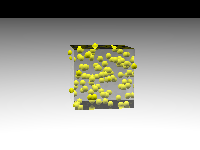

In [114]:
for t in range(0, 360, 4):    
    flnm = 'out_small/sphere_{:03}.png'.format(t // 4)
    scene = create_scene(t)
    scene.render(flnm, width=200, height=150)    
    clear_output()
    display(Image.open(flnm))